In [ ]:
import numpy as np 
import os
import json
import warnings 
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, image
from PIL import Image
from keras.applications import MobileNetV2
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

warnings.filterwarnings('ignore')

In [2]:
''' path of train, test and val data'''

path = "../input/coin-images/coins/data"

train_path =  path + '/train'
val_path = path + '/validation'
test_path =  path + '/test'

print(os.listdir("../input/coin-images/coins/data"))

['cat_to_name.json', 'validation', 'test', 'train']


In [3]:
''' reading data '''
with open('../input/coin-images/cat_to_name.json', 'r') as file:
    data = json.load(file)

print(data['200'])

1 Kurus,Turkish Lira,turkey


In [4]:
''' defining batch size'''
batch_size = 64

''' Data Augmentation '''
train_ds = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1, 
    height_shift_range=0.1,  
    horizontal_flip=True,
    featurewise_std_normalization=True,
    samplewise_std_normalization=True)

val_ds = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1, 
    height_shift_range=0.1,  
    horizontal_flip=True,
    featurewise_std_normalization=True,
    samplewise_std_normalization=True)

test_ds = ImageDataGenerator(
    featurewise_std_normalization=True,
    samplewise_std_normalization=True,
    rescale=1./255)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:348: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:355: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [5]:
""" it reads data from directory """
train_ds = train_ds.flow_from_directory(
        data_train_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

val_ds = val_ds.flow_from_directory(
        data_valid_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

test_ds = test_ds.flow_from_directory(
        data_test_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

Found 6413 images belonging to 211 classes.
Found 844 images belonging to 211 classes.
Found 844 images belonging to 211 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


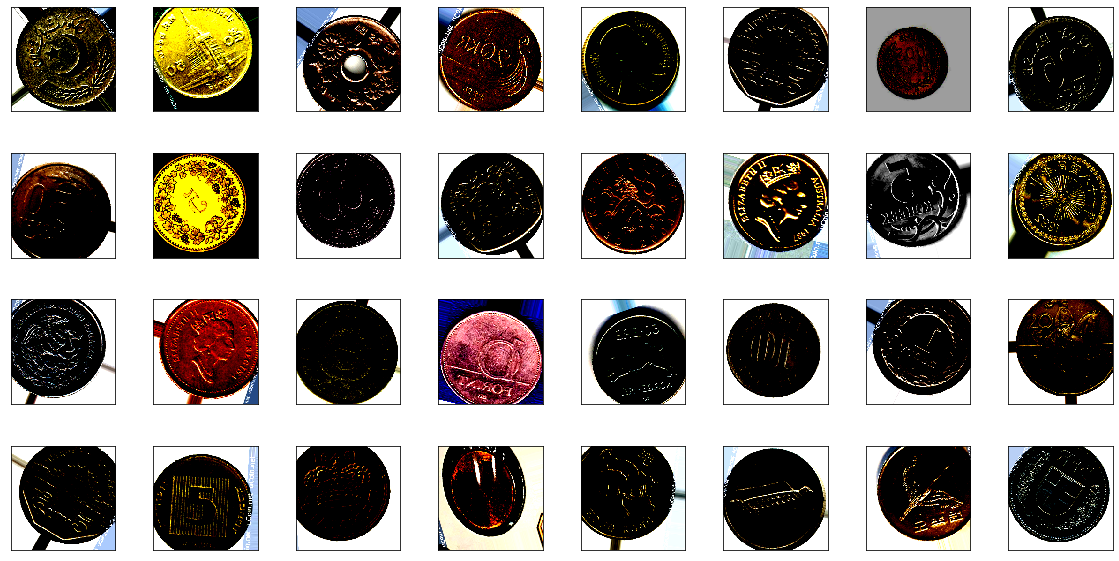

In [6]:
''' plotting some images'''
img, lbl = train_ds.next()

fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(wspace=0.2, hspace=0.4)

''' lets have a look on 32 images '''
for i, im in enumerate(img[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    img_idx = np.argmax(lbl[i])

In [7]:
''' Keras maps each folder (class) to a number. Create a dictionary that maps the number assigned by keras to our 
    folder real number '''
lbl_enc = {v: k for k, v in train_ds.class_indices.items()}

In [8]:
inp = Input(shape=(224, 224, 3))

''' MobileNetV2 Model '''
model1 = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_tensor=inp,
    input_shape=(224, 224, 3),
    pooling='avg')

for layer in model1.layers:
    layer.trainable = True  

''' classification layer '''
i = Dense(512, activation='relu')(base_model.output)
i = Dropout(.8)(i)

pred = Dense(211, activation='softmax')(i)

''' final model'''
model = Model(inputs=model1.input, outputs=pred)

9412608/9406464 [==============================] - 0s 0us/step


In [9]:
''' compile the model '''
model.compile(optimizer='adam', loss='categorical_crossentropy',
             metrics=['accuracy'])

In [10]:
''' length of train, val and test data '''
train_len = len(train_generator.filenames)
val_len = len(valid_generator.filenames)
test_len = len(train_generator.filenames)


''' When to save the model '''
cp = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

'''' Reduce learning rate when loss doesn't improve after n epochs'''
sc = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-8, verbose=1)

''' EarlyStopping: it prevents from overfitting '''
es = EarlyStopping(monitor='val_loss', patience=12, verbose=0, restore_best_weights=True)

''' training '''
history = model.fit_generator(train_ds, steps_per_epoch=train_len//batch_size, epochs=100, verbose=1, callbacks=[cp, sc, es],
                    validation_data=val_ds, validation_steps=val_len//batch_size)

Epoch 1/100


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


106/106 [==============================] - 195s 2s/step - loss: 5.5294 - accuracy: 0.0096 - val_loss: 5.5544 - val_accuracy: 0.0060

Epoch 00001: val_loss improved from inf to 5.55444, saving model to model.weights.best.hdf5
Epoch 2/100
106/106 [==============================] - 174s 2s/step - loss: 5.2079 - accuracy: 0.0266 - val_loss: 5.2655 - val_accuracy: 0.0332

Epoch 00002: val_loss improved from 5.55444 to 5.26554, saving model to model.weights.best.hdf5
Epoch 3/100
106/106 [==============================] - 179s 2s/step - loss: 4.9347 - accuracy: 0.0739 - val_loss: 4.9397 - val_accuracy: 0.0523

Epoch 00003: val_loss improved from 5.26554 to 4.93973, saving model to model.weights.best.hdf5
Epoch 4/100
106/106 [==============================] - 176s 2s/step - loss: 4.5140 - accuracy: 0.1349 - val_loss: 4.8857 - val_accuracy: 0.0816

Epoch 00004: val_loss improved from 4.93973 to 4.88570, saving model to model.weights.best.hdf5
Epoch 5/100
106/106 [==============================]

In [13]:
''' evaluation of model '''
result = model.evaluate_generator(test_ds, steps=test_len//1, verbose=1)
print('\n', 'Test accuracy:', result[1])

6413/6413 [==============================] - 4076s 636ms/step

 Test accuracy: 0.8424382209777832


In [14]:
''' norm function '''

def norm(img):
    img = np.expand_dims(img, axis=0)
    gen = ImageDataGenerator(featurewise_std_normalization=True, samplewise_std_normalization=True, rescale=1./255)
    img = gen.flow(img, y=None, batch_size=1)
    return img.next()

Predicted: 5 Cents,South African Rand,south_africa
Real:      5 Cents,South African Rand,south_africa

Predicted: 100 Forint,Hungarian Forint,hungary
Real:      20 Forint,Hungarian Forint,hungary

Predicted: 50 Satang,Thai Baht,thailand
Real:      50 Satang,Thai Baht,thailand

Predicted: 20 Kroner,Norwegian Krone,norway
Real:      20 Kroner,Norwegian Krone,norway

Predicted: 50 Cents,Canadian Dollar,canada
Real:      50 Cents,Canadian Dollar,canada

Predicted: 1 Piso,Philipine peso,philippines
Real:      1 Piso,Philipine peso,philippines

Predicted: 1 Baht,Thai Baht,thailand
Real:      1 Sen,Malaysian Ringgit,malaysia

Predicted: 5 Kronor,Swedish Krona,sweden
Real:      5 Kronor,Swedish Krona,sweden

Predicted: 5 Rupees,Pakistan Rupee,pakistan
Real:      5 Rupees,Pakistan Rupee,pakistan

Predicted: 200 Forint,Hungarian Forint,hungary
Real:      200 Forint,Hungarian Forint,hungary



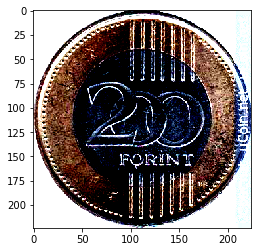

In [15]:
''' prediction function '''
def prediction(img, lbl):
    ''' converting image into array'''
    img = image.img_to_array(img)/255
    
    ''' mean, std '''
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = (img - mean)/std
    img = np.expand_dims(img, axis=0)

    ''' prediction '''
    pred = model.predict(img)
    ypred = np.argmax(pred)

    lbl_int = int_to_dir[ypred]
    lbl_name = data[str(lbl_int)]
    
    ''' plotting image'''
    plt.imshow(img)
    
    print("Predicted: {}\nReal:      {}".format(lbl_name, data[str(lbl)]))
    print()

for i in range(10):
    idx = np.random.randint(0, len(test_generator.filenames))
    img = test_generator.filenames[idx]
    img = image.load_img("../input/coin-images/coins/data/test/"+img, target_size=(224,224))
    lbl = test_generator.filenames[idx].split("/")[0]
    prediction(img, lbl)